In [1]:
"""
Compare the output of our wind model (Holland, downscaled with local surface roughness)
against the footprints of Done et al. (Willougby with numerical boundary layer simulation)
"""

'\nCompare the output of our wind model (Holland, downscaled with local surface roughness)\nagainst the footprints of Done et al. (Willougby with numerical boundary layer simulation)\n'

In [2]:
import contextily as cx
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import shapely

import os
from glob import glob

/tmp/ipykernel_2876257/175038480.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
def grid_point_data(point_speeds: gpd.GeoDataFrame, col_name: str, agg_func_name: str, delta: float = 0.1) -> gpd.GeoDataFrame:
    """
    Bin data on a regular grid. Grid will snap to integer number of `delta` from CRS reference.
    
    Args:
        point_speeds: Table of data at point locations
        col_name: Data column to rebin
        agg_func: Name of function to apply to multiple points within a bin, e.g. max, mean
        delta: Width and height of output raster pixels in decimal degrees
    """
    
    def n_cells(start: float, end: float, width: float) -> int:
        return round((end - start) / width)

    # create grid

    # unpack and snap extrema to integer number of cells from CRS reference
    min_x, min_y, max_x, max_y = map(lambda x: np.ceil(x / delta) * delta, point_speeds.total_bounds)

    cells = []
    for x0 in np.linspace(min_x, max_x, n_cells(min_x, max_x, delta) + 1):
        x1 = x0 + delta
        for y0 in np.linspace(min_y, max_y, n_cells(min_y, max_y, delta) + 1):
            y1 = y0 + delta
            cells.append(shapely.geometry.box(x0, y0, x1, y1))

    grid = gpd.GeoDataFrame({"geometry": cells})

    # associate points with grid
    raster = grid.sjoin(point_speeds, how="inner")

    # take aggregate of arbitrary number of rows (points) grouped by cell
    agg_func = getattr(raster.groupby(raster.index), agg_func_name)
    aggregated = agg_func(col_name)
    
    # merge geometry back in, how="right" for every grid cell, empty or not
    rebinned = aggregated.merge(grid[["geometry"]], left_index=True, right_index=True, how="right")
    rebinned = rebinned.drop(columns=["index_right"])
    
    # cast to GeoDataFrame again (merge reverted to DataFrame) and return
    return gpd.GeoDataFrame(rebinned)

In [4]:
def to_xarray(cells: gpd.GeoDataFrame) -> xr.Dataset:
    """
    Given table of polygon cells, export to xarray
    """
    to_export = cells
    to_export["longitude"] = to_export.geometry.centroid.x
    to_export["latitude"] = to_export.geometry.centroid.y
    to_export = to_export.drop(columns=["geometry"])
    to_export = to_export.set_index(["longitude", "latitude"])
    return to_export.to_xarray()

In [5]:
def read_kw01(name_year: str, delta: float) -> gpd.GeoDataFrame:
    """
    Read the KW01 data, wrangle as points in GeoDataFrame
    
    Args:
        name_year: Storm identifier, e.g. IRMA_2017 or IKE_2008
        delta: Grid resolution to return at in decimal degrees
    """
    
    data = pd.concat(
        [
            pd.read_csv(path, delimiter=r',\s+')
            for path in glob(f"/home/fred/projects/WRN_TC_footprints/footprints/regions/*/{name_year}/*.txt")
        ]
    )
    point_speeds = gpd.GeoDataFrame(
        {
            "max_wind_speed": data["wind(m/s)"],
            "geometry": gpd.points_from_xy(data.lon, data.lat)
        }
    )

    return to_xarray(grid_point_data(point_speeds, "max_wind_speed", "max", delta=delta))

In [6]:
def fig_size(
    min_x: float,
    min_y: float,
    max_x: float,
    max_y: float,
    max_width_in: float = 16,
    max_height_in: float = 9
) -> tuple[float, float]:
    """
    Given bounding box, calculate size of figure in inches for equal aspect ratio.
    
    Returns:
        width in inches, height in inches
    """
    x_span = max_x - min_x
    y_span = max_y - min_y
    aspect_ratio = y_span / x_span
    max_plot_width_in = 16
    max_plot_height_in = 9

    if max_plot_width_in * aspect_ratio < max_plot_height_in:
        # tall
        x_in = max_plot_width_in
        y_in = max_plot_width_in * aspect_ratio

    else:
        # wide
        x_in = max_plot_height_in / aspect_ratio
        y_in = max_plot_height_in
        
    return x_in, y_in

In [7]:
def name_year_from_id(tracks: gpd.GeoDataFrame, storm_id: str) -> str:
    """
    Given IBTrACS storm ID, return name_year.
    e.g. "2017242N16333" -> "IRMA_2017"
    """
    storm_track = tracks[tracks.track_id==storm_id]
    track_point = storm_track.iloc[0]
    name = track_point["name"]
    year = track_point["year"]
    return f"{name}_{year}"

def id_from_name_year(tracks: gpd.GeoDataFrame, name_year: str) -> str | None:
    """
    Given name_year, return IBTrACS storm ID.
    e.g. "IRMA_2017" -> "2017242N16333"
    """
    try:
        name, year = name_year.split("_")
    except ValueError:
        print(f"skipping {name_year}...")
        return None
    track = tracks[(tracks.name==name) & (tracks.year==int(year))]
    try:
        storm_id, = set(track.track_id)
    except ValueError:
        print(f"{name_year} is ambiguous: {set(track.track_id)}, skipping...")
        return None
    return storm_id

In [8]:
def map_ratio(field_ratio: xr.DataArray, storm_track: gpd.GeoDataFrame, storm_id: str, plot_dir: str):
    """
    Plot a DataArray of the ratio of two wind fields.
    Uses diverging colourmap centered around 1.
    """
    
    f, ax = plt.subplots(
        figsize=fig_size(
            field_ratio.longitude.min(),
            field_ratio.latitude.min(),
            field_ratio.longitude.max(),
            field_ratio.latitude.max()
        )
    )

    divider = make_axes_locatable(ax)
    ratio_cax = divider.append_axes("right", size="2%", pad=0.05)
    xr.plot.pcolormesh(
        field_ratio,
        x="longitude",
        y="latitude",
        cmap="bwr",
        levels=np.linspace(0, 2, 10),
        extend="neither",
        alpha=0.5,
        ax=ax,
        cbar_ax=ratio_cax
    )
    ratio_cax.set_ylabel(r"$\frac{\mathrm{Downscaled \ Holland}}{\mathrm{Kepert \ Wang \ 2001}}$", labelpad=10)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{storm_id.replace('_', ', ')}")
    
    min_x, max_x = ax.get_xlim()
    min_y, max_y = ax.get_ylim()
    
    track_cax = divider.append_axes("right", size="2%", pad=1)
    storm_track.plot(
        ax=ax,
        column="max_wind_speed_ms",
        cmap="viridis",
        alpha=1,
        vmin=0,
        vmax=80,
        legend=True,
        legend_kwds={
            "label": "IBTrACS maximum wind speed [ms-1]",
            "cax": track_cax
        }
    )
    
    cx.add_basemap(
        ax,
        crs=storm_track.crs.to_string(),
        source=cx.providers.Stamen.TonerLite
    )

    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    ax.grid(alpha=0.3)
    
    f.savefig(os.path.join(plot_dir, f"{storm_id}.png"))
    plt.close(f)
    
    return

In [9]:
def landfalling_ratio(
    storm_track: gpd.GeoDataFrame,
    ratio_field: xr.DataArray,
    buffer_radius_km: float,
    minimum_speed_ms: float,
) -> np.ndarray:
    """
    Return the ratio values from `ratio_field` within a certain distance of points in `storm_track`
    """
    
    # make a buffer around the fast, on-land track
    fast_track = storm_track[storm_track.max_wind_speed_ms > minimum_speed_ms]
    land_track = fast_track[fast_track.landfall == True]
    land_track_3857 = land_track.to_crs(3857)
    buffer = land_track_3857.buffer(buffer_radius_km * 1000).to_crs(4326)
    land_track.loc[:, "geometry"] = buffer

    # get the ratio field as gpd points
    ratio_df = ratio_field.to_dataframe().reset_index()
    ratio_gdf = gpd.GeoDataFrame(
        {
            "ratio": ratio_df.max_wind_speed,
            "geometry": gpd.points_from_xy(ratio_df.longitude, ratio_df.latitude)
        }                                
    ).set_crs(4326)

    # find the intersection
    land_ratio_gdf = ratio_gdf.sjoin(land_track, how="inner")
    
    return land_ratio_gdf.ratio.values

In [13]:
def plot_ratio_distribution(
    pooled_ratio: np.ndarray,
    buffer_km: float,
    minimum_speed_ms: float,
    filepath: str
) -> None:
    """
    Plot distribution of wind speed errors w.r.t Done et al.
    
    pooled_ratio: 1D array of ratios to bin.
    """

    f, ax = plt.subplots(figsize=(8, 5))

    mean = np.nanmean(pooled_ratio)
    median = np.nanmedian(pooled_ratio)
    n = len(pooled_ratio)

    ax.set_title(
        (
            "Wind model validation against Done et al.\n"
            f"for pixels < {buffer_km}km from eye, with model speed > {minimum_speed_ms}ms$^{{-1}}$\n"
            f"$n_{{pixels}}={n}, \ \mu={mean:.3f}, \ q_{{50}}={median:.3f}$"
        ),
        pad=15
    )
    ax.set_xlabel("Downscaled Holland / Done et al.", labelpad=10)
    ax.set_ylabel("Frequency", labelpad=10)

    frequency, bin_edges, _ = ax.hist(
        pooled_ratio,
        bins=np.linspace(0, 3, 121),
        color="g",
        alpha=0.5,
        density=True,
        label="PDF"
    )

    ax.axvline(mean, color="r", ls="--", label="Mean", alpha=0.5)
    miny, maxy = ax.get_ylim()
    for probability_level in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
        quantile = np.quantile(pooled_ratio, probability_level)
        ax.axvline(quantile, color="pink", ls="--", alpha=0.6)
        ax.text(
            quantile,
            0.07 * maxy,
            f"$\mathrm{{q}}_{{{probability_level:.2f}}}$",
            rotation=-90,
            ha="center",
            size=9
        )

    ax.set_xlim(0.25, 2)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.subplots_adjust(top=0.8, bottom=0.15)

    f.savefig(filepath)
    plt.close(f)

In [11]:
tracks = gpd.read_parquet(
    "/home/fred/projects/open_gira/open-gira/results/storm_tracks/IBTrACS/tracks.geoparquet"
)
holland_storms_id = {
    path.split("/")[-1] for path in
    glob("/home/fred/projects/open_gira/open-gira/results/power/by_storm_set/IBTrACS/by_storm/*")
}
holland_storms_name_year = {
    name_year_from_id(tracks, storm_id) for storm_id in
    holland_storms_id
}
wrn_storms_name_year = {
    path.split("/")[-2] for path in
    glob(f"/home/fred/projects/WRN_TC_footprints/footprints/regions/*/*/*.txt")
}
common_storms_name_year = holland_storms_name_year & wrn_storms_name_year
common_storms_id = [
    id_from_name_year(tracks, name_year)
    for name_year in common_storms_name_year
]
common_storms = sorted(filter(bool, common_storms_id))

print(f"{len(holland_storms_name_year)=}")
print(f"{len(wrn_storms_name_year)=}")
print(f"{len(common_storms)=}")

JOYCE_2018 is ambiguous: {'2018007S13130', '2018255N37320'}, skipping...
skipping NOT_NAMED_2013...
skipping NOT_NAMED_2017...
skipping NOT_NAMED_2007...
skipping NOT_NAMED_2010...
TOMAS_2010 is ambiguous: {'2010302N09306', '2010069S12188'}, skipping...
skipping NOT_NAMED_2016...
skipping NOT_NAMED_2005...
len(holland_storms_name_year)=736
len(wrn_storms_name_year)=743
len(common_storms)=413


In [65]:
buffer_km = 300
for minimum_speed_ms in [0, 10, 20, 30, 40, 50, 60, 70]:
    plot_dir_frames = (
        "/home/fred/projects/open_gira/open-gira/validation/holland_done_ratio/"
        f"buffer-km-{int(buffer_km)}_min-speed-{int(minimum_speed_ms)}"
    )
    os.makedirs(plot_dir_frames, exist_ok=True)
    
    # store the ratios for later
    ravel_ratio = {}
    for i, storm_id in enumerate(common_storms):

        name_year = name_year_from_id(tracks, storm_id)
        storm_track = tracks[tracks.track_id == storm_id]

        # filter out weak storms
        if storm_track.max_wind_speed_ms.max() < minimum_speed_ms:
            continue

        try:
            kw01 = (
                read_kw01(name_year, delta=0.1)
                    .interpolate_na(dim="longitude", method="linear")
                    .interpolate_na(dim="latitude", method="linear")
            )
        except ValueError:
            print(f"couldn\'t read kw01 for {name_year}, skipping...")
            continue
        try:
            holland = xr.open_dataset(
                (
                    "/home/fred/projects/open_gira/open-gira/"
                    f"results/power/by_storm_set/IBTrACS/by_storm/{storm_id}/wind_field.nc"
                )
            )
        except FileNotFoundError:
            print(f"couldn\'t find holland for {name_year}, skipping...")
            continue

        try:
            ratio_field = (holland / kw01).max_wind_speed
        except ValueError:
            print(f"couldn\'t calculate the division for {name_year}, skipping...")
            continue

        # make a buffer around the on-land track      
        print(name_year)
        ravel_ratio[storm_id] = landfalling_ratio(storm_track, ratio_field, buffer_km, minimum_speed_ms)

    #     map_ratio(
    #         ratio_field,
    #         storm_track,
    #         f"{name_year}_{storm_id}",
    #         "validation/plots/wind_fields/"
    #     )

        print(f"{len(ravel_ratio)=} storms compared...")
        pooled_ratio = np.concatenate(list(ravel_ratio.values()))
        pooled_ratio = pooled_ratio[~np.isnan(pooled_ratio)]            
        print(f"{len(pooled_ratio)=} pixel-wise comparisons...")
        if len(pooled_ratio) == 0:
            print("no data, skipping...")
            continue

        print("plotting distribution...")
        plot_ratio_distribution(
            pooled_ratio,
            buffer_km,
            minimum_speed_ms,
            os.path.join(
                plot_dir_frames,
                f"{i:04d}.png"
            )
        )

    print("saving ratios to disk...")
    basename = f"buffer-km-{buffer_km}_min-speed-{int(minimum_speed_ms)}"
    plot_dir = "/home/fred/projects/open_gira/open-gira/validation/holland_done_ratio"
    data_filepath = os.path.join(plot_dir, basename + ".npy")
    np.save(data_filepath, pooled_ratio)

    print("plotting distribution...")
    plot_ratio_distribution(
        pooled_ratio,
        buffer_km,
        minimum_speed_ms,
        os.path.join(plot_dir, basename + ".png")
    )

    print("animating convergence...")
    frame_filepaths = glob(os.path.join(plot_dir_frames, "*.png"))
    os.system(
        "convert -delay 5 "
        f"{' '.join(sorted(frame_filepaths))} "
        f"{os.path.join(plot_dir, basename)}.gif"
    )

/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PABUK_2001
len(ravel_ratio)=1 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DANAS_2001
len(ravel_ratio)=2 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NARI_2001
len(ravel_ratio)=3 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LEKIMA_2001
len(ravel_ratio)=4 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


IRIS_2001
len(ravel_ratio)=5 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LINGLING_2001
len(ravel_ratio)=6 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHATAAN_2002
len(ravel_ratio)=7 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RAMMASUN_2002
len(ravel_ratio)=8 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HALONG_2002
len(ravel_ratio)=9 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FENGSHEN_2002
len(ravel_ratio)=10 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SINLAKU_2002
len(ravel_ratio)=11 storms compared...
len(pooled_ratio)=0 pixel-wise comparisons...
no data, skipping...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LILI_2002
len(ravel_ratio)=12 storms compared...
len(pooled_ratio)=5812 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HIGOS_2002
len(ravel_ratio)=13 storms compared...
len(pooled_ratio)=5812 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KENNA_2002
len(ravel_ratio)=14 storms compared...
len(pooled_ratio)=8891 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


INIGO_2003
len(ravel_ratio)=15 storms compared...
len(pooled_ratio)=8891 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SOUDELOR_2003
len(ravel_ratio)=16 storms compared...
len(pooled_ratio)=8891 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CLAUDETTE_2003
len(ravel_ratio)=17 storms compared...
len(pooled_ratio)=8891 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


IMBUDO_2003
len(ravel_ratio)=18 storms compared...
len(pooled_ratio)=17639 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ETAU_2003
len(ravel_ratio)=19 storms compared...
len(pooled_ratio)=17639 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KROVANH_2003
len(ravel_ratio)=20 storms compared...
len(pooled_ratio)=17639 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


IGNACIO_2003
len(ravel_ratio)=21 storms compared...
len(pooled_ratio)=17639 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DUJUAN_2003
len(ravel_ratio)=22 storms compared...
len(pooled_ratio)=17639 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAEMI_2003
len(ravel_ratio)=23 storms compared...
len(pooled_ratio)=20088 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ISABEL_2003
len(ravel_ratio)=24 storms compared...
len(pooled_ratio)=20088 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MARTY_2003
len(ravel_ratio)=25 storms compared...
len(pooled_ratio)=22624 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NORA_2003
len(ravel_ratio)=26 storms compared...
len(pooled_ratio)=22624 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MONTY_2004
len(ravel_ratio)=27 storms compared...
len(pooled_ratio)=23045 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NIDA_2004
len(ravel_ratio)=28 storms compared...
len(pooled_ratio)=25505 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ERNEST_2005
len(ravel_ratio)=29 storms compared...
len(pooled_ratio)=25505 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DENNIS_2005
len(ravel_ratio)=30 storms compared...
len(pooled_ratio)=47779 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


EMILY_2005
len(ravel_ratio)=31 storms compared...
len(pooled_ratio)=49063 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HAITANG_2005
len(ravel_ratio)=32 storms compared...
len(pooled_ratio)=50639 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MATSA_2005
len(ravel_ratio)=33 storms compared...
len(pooled_ratio)=50639 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAWAR_2005
len(ravel_ratio)=34 storms compared...
len(pooled_ratio)=50639 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KATRINA_2005
len(ravel_ratio)=35 storms compared...
len(pooled_ratio)=53857 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TALIM_2005
len(ravel_ratio)=36 storms compared...
len(pooled_ratio)=56834 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NABI_2005
len(ravel_ratio)=37 storms compared...
len(pooled_ratio)=56834 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RITA_2005
len(ravel_ratio)=38 storms compared...
len(pooled_ratio)=58029 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OTIS_2005
len(ravel_ratio)=39 storms compared...
len(pooled_ratio)=58029 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BETA_2005
len(ravel_ratio)=40 storms compared...
len(pooled_ratio)=59577 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GLENDA_2006
len(ravel_ratio)=41 storms compared...
len(pooled_ratio)=59577 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAEMI_2006
len(ravel_ratio)=42 storms compared...
len(pooled_ratio)=59577 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SAOMAI_2006
len(ravel_ratio)=43 storms compared...
len(pooled_ratio)=61225 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JOHN_2006
len(ravel_ratio)=44 storms compared...
len(pooled_ratio)=63601 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LANE_2006
len(ravel_ratio)=45 storms compared...
len(pooled_ratio)=66154 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


XANGSANE_2006
len(ravel_ratio)=46 storms compared...
len(pooled_ratio)=84824 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PAUL_2006
len(ravel_ratio)=47 storms compared...
len(pooled_ratio)=84824 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_2876257/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KeyboardInterrupt: 

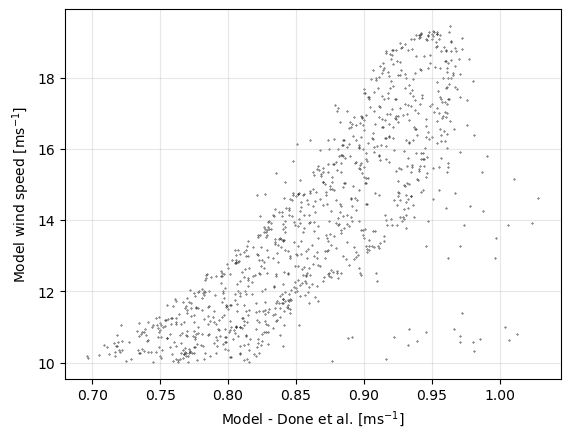

In [66]:
# TODO: look at modelled windspeed errors as function of wind speed
# would be good to also do this for all the pixels available, might need datashader

model = holland.sel(
    dict(
        longitude=ratio_field.longitude,
        latitude=ratio_field.latitude
    )
).max_wind_speed.values
difference = ratio_field.values

f, ax = plt.subplots()
ax.scatter(difference, model, s=0.1, c="k")
ax.set_ylabel("Model wind speed [ms$^{-1}$]")
ax.set_xlabel("Model - Done et al. [ms$^{-1}$]")
ax.grid(alpha=0.3)